# Imports and Colne

In [74]:
!rm -rf CNN_Image_Classsification
!git clone https://github.com/JasimJashore/CNN_Image_Classsification.git

Cloning into 'CNN_Image_Classsification'...
remote: Enumerating objects: 77057, done.
remote: Counting objects: 100% (4562/4562), done.
remote: Compressing objects: 100% (4558/4558), done.
remote: Total 77057 (delta 19), reused 4523 (delta 0), pack-reused 72495 (from 1)
Receiving objects: 100% (77057/77057), 513.21 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os


## Transforms


In [76]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


## Dataset & DataLoaders

In [77]:
dataset = datasets.ImageFolder("CNN_Image_Classsification/dataset/train_data", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

class_names = dataset.classes
print(class_names)


['circle', 'square', 'triangle']


### CNN Model

In [78]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)


## Training Loop

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 10

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accs[-1]:.4f}")


Epoch 1/10 - Train Acc: 0.6936
Epoch 2/10 - Train Acc: 0.9717
Epoch 3/10 - Train Acc: 0.9931
Epoch 4/10 - Train Acc: 0.9931
Epoch 5/10 - Train Acc: 0.9983
Epoch 6/10 - Train Acc: 0.9997
Epoch 7/10 - Train Acc: 0.9972
Epoch 8/10 - Train Acc: 0.9989
Epoch 9/10 - Train Acc: 0.9997
Epoch 10/10 - Train Acc: 1.0000


## **Save** Model

In [80]:
torch.save(model.state_dict(), "model/210136.pth")


# Training Curves

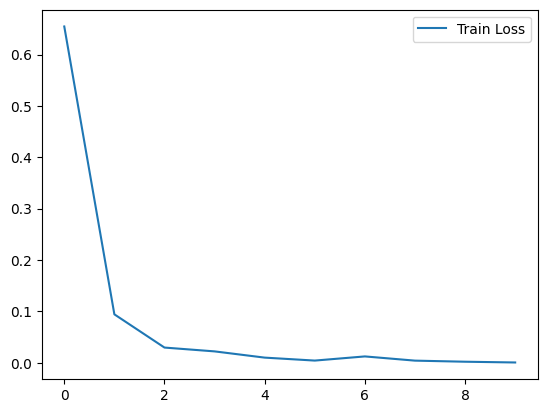

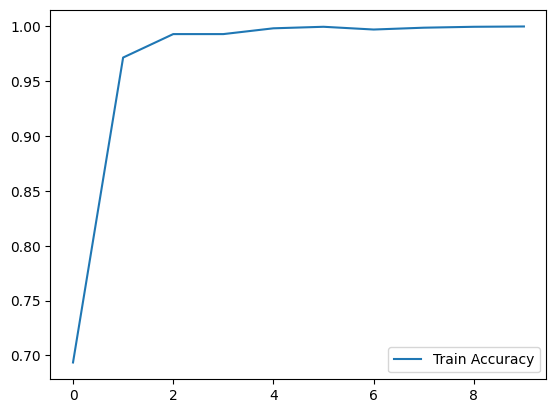

In [81]:
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Accuracy")
plt.legend()
plt.show()


## Confusion Matrix

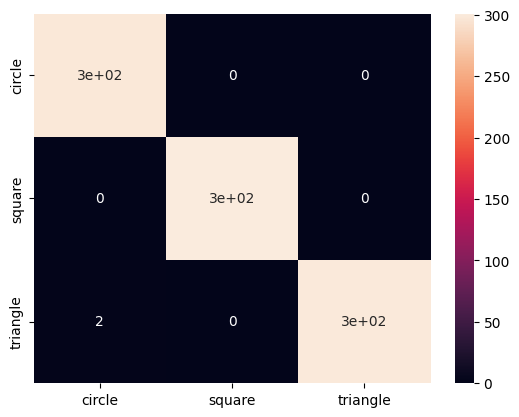

In [82]:
from sklearn.metrics import confusion_matrix

all_preds, all_labels = [], []
model.eval()

for imgs, labels in val_loader:
    outputs = model(imgs.to(device))
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu())
    all_labels.extend(labels)

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()


## Real-World Prediction by Phone Image



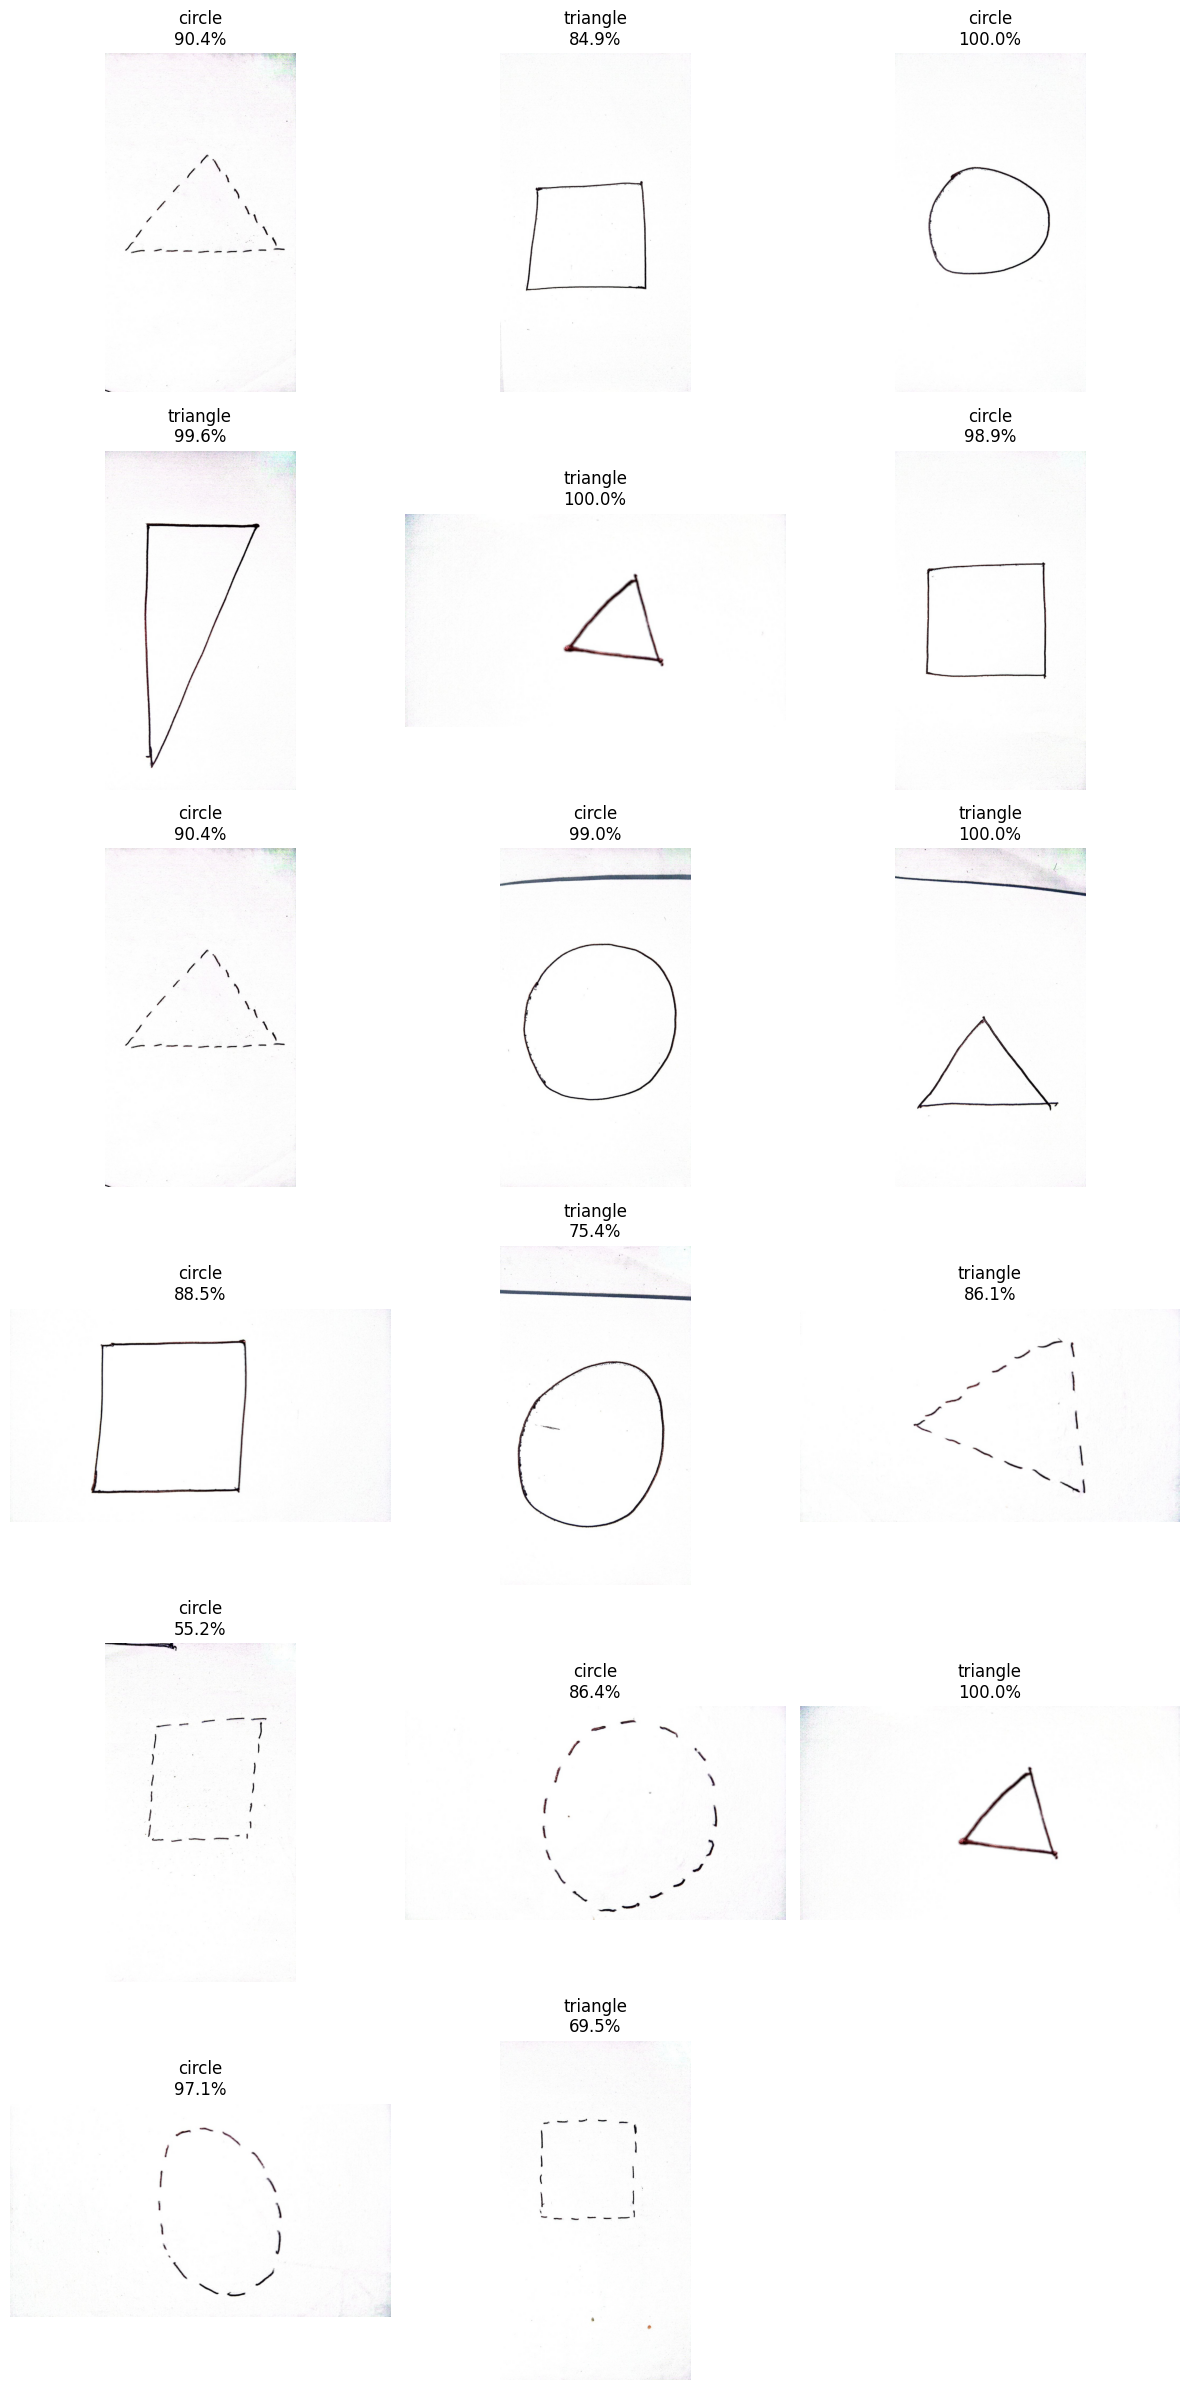

In [83]:
import math

images = os.listdir(custom_dir)
cols = 3
rows = math.ceil(len(images) / cols)

plt.figure(figsize=(12, 4 * rows))

for i, img_name in enumerate(images):
    img_path = os.path.join(custom_dir, img_name)
    img = Image.open(img_path).convert("RGB")

    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"{class_names[pred.item()]}\n"
        f"{conf.item()*100:.1f}%"
    )

plt.tight_layout()
plt.show()

In [84]:
import torch
import os

os.makedirs("model", exist_ok=True)

torch.save(model.state_dict(), "model/210136.pth")

In [85]:
from google.colab import files
files.download("model/210136.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>